Todo esse material é embassado pro: https://github.com/arnaldog12/Machine_Learning


In [32]:
!pip install tensorflow pandas matplotlib
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


In [43]:
#Dados e pre-processamento
# Carregar o banco de dados
data = pd.read_csv("/content/sample_data/BD_Jean_98000.csv")
# Passo 1: Análise inicial
print("Primeiras linhas do conjunto de dados:")
print(data.head())
print("\nInformações gerais sobre o conjunto de dados:")
print(data.info())
print("\nEstatísticas descritivas:")
print(data.describe())

# Verificar se há valores ausentes
missing_values = data.isnull().sum()
print("\nValores ausentes em cada coluna:")
print(missing_values)

# Passo 2: Separação de variáveis de entrada (X) e saída (y)
X = data[['T', 'w', 'i']]
y = data['V']

# Passo 3: Divisão em conjunto de treino e teste (80% treino e 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 4: Normalização dos dados de entrada
scaler = StandardScaler()  # Utilizamos StandardScaler para escalonar as variáveis para média 0 e desvio padrão 1
X_train = scaler.fit_transform(X_train)  # Ajustar o escalonador nos dados de treino e transformá-los
X_test = scaler.transform(X_test)        # Apenas transformar os dados de teste para garantir a mesma escala

# Normalizamos os dados de entrada X para que cada variável tenha média zero e desvio padrão um.
# A normalização ajuda a evitar que variáveis com diferentes faixas de valores influenciem de forma desigual no treinamento do modelo.

Primeiras linhas do conjunto de dados:
           T           w           i           V
0   6.283921  100.000000    0.000000  267.400000
1   7.813127   98.441656  131.387061  267.400000
2   9.337215  129.791422  146.812732  262.891184
3  10.844529  164.663253  117.004939  226.221634
4  12.323660  191.605370   52.795829  226.306979

Informações gerais sobre o conjunto de dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96918 entries, 0 to 96917
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       96918 non-null  float64
 1   w       96918 non-null  float64
 2   i       96918 non-null  float64
 3   V       96918 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
None

Estatísticas descritivas:
                  T             w             i             V
count  96918.000000  96918.000000  96918.000000  96918.000000
mean      24.398716    180.851458     22.841796    227.690284
std        2.411280     32.79641

606/606 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Erro Médio Absoluto (MAE) no conjunto de teste: 0.13


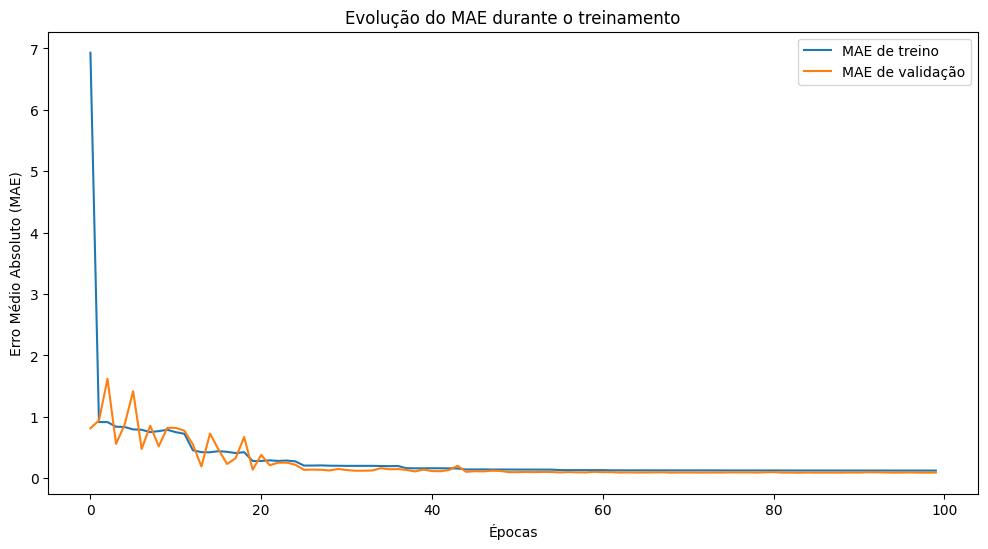

In [46]:
#Modelos e treinamentos, estou rodando 3 modelos diferentes para verificar qual será o mais performatico e ajustando seus parametros
# VERSÃO 1.0 treiamentos sem callback e sem tratamento de preprocessamento
# VERSÃO 2.0 Treinamento com erly stopping e reduce lr para tentar contornar overfitting
# VERSÃO 3.0 Pre processamento e tirar o early stopping
# E também reduzindo o tamanho do lote para variaveis mais rapido.

# V1.0 - Modelo teste 1 0.53 MAE
#V2.0 - MAE 0.32, reduzindo significativamente provando que a base precisava de tratamento e também precisamos ajustar o overfitting
# OBS: acho que cheguei na minha cota maxima, pois o treinamento nao fez as 100 epochs.
model = Sequential([
  Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(1, activation='linear')
])

# V1.0 Modelo teste 2 0.95 MAE - Muito abaixo do esperado a arquitetura 1 se sobressaiu muito
# v2.0 na versão ajustada MAE 0.35 - Muito melhor do que o esperado provavendo que o pre processamento + funções previnindo overfitting tiveram bastante resulta
# model = Sequential([
#    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
#    Dense(16, activation='relu'),
#    Dense(1, activation='linear')
# ])

# V1.0 Modelo teste 3 0.51 MAE -- VENCEDOR e reduzindo o numero de neuronios // PROVAVELMENTE OVERFITTING
# V2.0 0.33 MAE -- provando assim que o problema era overfitting pois o modelo 64x128x64 se provou ser melhor
# model = Sequential([
#     Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
#     Dense(16, activation='relu'),
#     Dense(1, activation='linear')
# ])

# Compilar o modelo
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-5)
# Treinar o modelo
history = model.fit(
    X_train, y_train,
    epochs=100,            # Número de épocas
    batch_size=16,         # Tamanho do lote
    validation_split=0.2,  # Porcentagem dos dados reservada para validação
    verbose=1,             # Nível de detalhe no console (barra de progresso)
    callbacks=[reduce_lr]  # Callbacks para monitorar o treinamento
)

# Avaliar o modelo no conjunto de teste
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Erro Médio Absoluto (MAE) no conjunto de teste: {mae:.2f}")
# Plotar a evolução do erro durante o treinamento
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='MAE de treino')
plt.plot(history.history['val_mae'], label='MAE de validação')
plt.xlabel('Épocas')
plt.ylabel('Erro Médio Absoluto (MAE)')
plt.legend()
plt.title('Evolução do MAE durante o treinamento')
plt.show()

# Salvar o modelo para interação com o motor (nomeando-o como motorccRNA)
model.save("motorcc64x128x64RNAV3.keras")

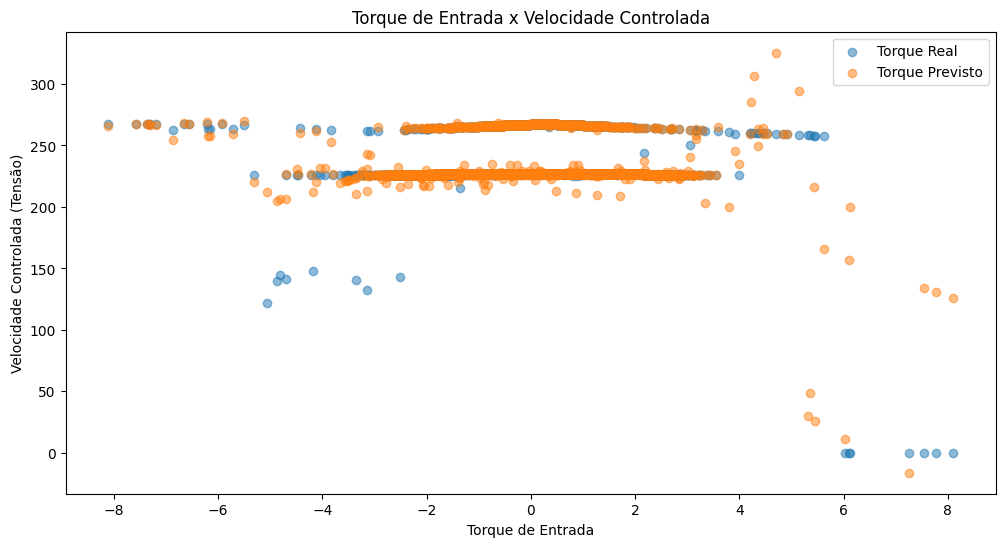

In [37]:
plt.figure(figsize=(12, 6))
plt.scatter(X_test[:, 0], y_test, label='Torque Real', alpha=0.5)  # Accessing the first column (index 0) for 'T'
plt.scatter(X_test[:, 0], y_pred, label='Torque Previsto', alpha=0.5)  # Accessing the first column (index 0) for 'T'
plt.xlabel('Torque de Entrada')
plt.ylabel('Velocidade Controlada (Tensão)')
plt.legend()
plt.title('Torque de Entrada x Velocidade Controlada')
plt.show()